# CISC3024 Pattern Recognition Final Project
## Group Members:
- Huang Yanzhen, DC126732
- Mai Jiajun, DC12785

## 0. Project Setup

### 0.1 Packages & Device

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import numpy as np
import cv2
import os

In [4]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print(f"Using device: {device_name}")

Using device: cuda


### 0.2 Global Configurations

In [65]:
path_dataset = "./data/SVHN_mat"
norm_mean = [0.4377, 0.4438, 0.4728]
norm_std = [0.1980, 0.2010, 0.1970]

## 1. Data Processing and Augmentation

### 1.1 Download Datasets
Define dataset class, retrieve dataset.

In [66]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import scipy.io as sio

In [67]:
class SVHNDataset(Dataset):
    def __init__(self, mat_file, transform=None):
        data = sio.loadmat(mat_file)
        self.images = np.transpose(data['X'], (3, 0, 1, 2))
        self.labels = data['y'].flatten()
        self.labels[self.labels == 10] = 0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [68]:
transform = A.Compose([
    A.RandomResizedCrop(32, 32),
    A.Rotate(limit=30),
    A.Normalize(mean=norm_mean, std=norm_std),
    ToTensorV2()
])

train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"train_32x32.mat"), transform=transform)
test_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"test_32x32.mat"), transform=transform)
extra_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"extra_32x32.mat"), transform=transform)

### 1.2 Peak A Data

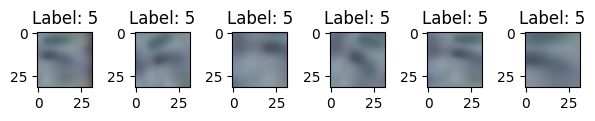

In [112]:
def unnormalize(img, mean, std):
    """Revert the normalization for visualization."""
    img = img * std + mean
    return np.clip(img, 0, 1)

# Plotting multiple images in a grid
grid_rows, grid_cols = 1, 6

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(6, 6))

for i in range(grid_cols):
    img_tensor, label = train_dataset.__getitem__(5)
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    img = unnormalize(img, norm_mean, norm_std)

    ax = axes[i]  # Get subplot axis
    ax.imshow(img)
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

## 2. Neuron Network Structure

In [113]:
from torchviz import make_dot

In [120]:
class SmallVGG(nn.Module):
    def __init__(self):
        super(SmallVGG, self).__init__()
        self. conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 7x7

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 3x3
        )
    
        self.fc_layers = nn.Sequential(
            nn.Linear(32*3*3, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

viz_model = SmallVGG()
dummy_img_tensor, dummy_label = train_dataset.__getitem__(0)
y = viz_model(dummy_img_tensor)
graph = make_dot(y, params=dict(viz_model.named_parameters()))

# Save or render the graph
graph.render("small_vgg_model", format="png")

RuntimeError: Given groups=1, weight of size [8, 1, 3, 3], expected input[1, 3, 32, 32] to have 1 channels, but got 3 channels instead